In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cbr1krr = pd.read_csv('cbr1kr.csv')
hayabusa = pd.read_csv('hayabusa.csv')

cbr = cbr1krr.to_numpy()
haya = hayabusa.to_numpy()

cbr_rpm_Nm = cbr[:,[0,4]]

In [ ]:
# constants
mass = 500 #kg
wheel_rad = .3 #m
rear_weight = .55 #fraction out of 1
tire_mu = 1
final_drive = 8
CG_height = .4 #m
Coef_drag = .4
frontal_A = 6 #m^2
Rho = 1.204 # kg/m^3
wheel_base = 1.8 #m

cbr_gears = np.array([2.286, 1.778, 1.5, 1.333, 1.214, 1.138])
gear = cbr_gears


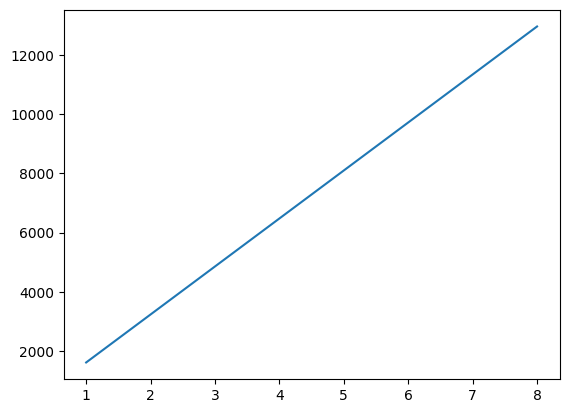

In [4]:
top_speed_mph = 100
top_speed_mps = top_speed_mph * .44704 #conversion from mph to m/s

final_drive_ratios = np.linspace(1,8,80)
top_speed_rpm = np.zeros_like(final_drive_ratios)

for fd_idx, fd_val in enumerate(final_drive_ratios):
    top_speed_rpm[fd_idx] = top_speed_mps / (2 * np.pi * wheel_rad) * fd_val * gear[5] * 60

plt.plot(final_drive_ratios, top_speed_rpm)

In [ ]:
def final_drive_for_top_speed(top_speed_mph):
    top_speed_mps = top_speed_mph * .44704
    final_drive_ratio = 13000 / 60 / gear[5] * .6 * np.pi / top_speed_mps
    return final_drive_ratio

def top_speed_for_final_drive(final_drive): # mph
    return 13000 / final_drive / gear[5] / 60 * .6 * np.pi / .44704

def rpm_for_speed_gear(speed, g): #m/s and an int 0 - 5 for 1 - 6 gears
    final_drive = 8
    return speed / (.6 * np.pi) * final_drive * gear[g] * 60

def thrust(t, g, FD = final_drive, WR = wheel_rad):
    return t * gear[g] * FD / WR

def drag(v, rho = Rho, FA = frontal_A, Cd = Coef_drag):
    return (v**2) * rho * Cd * FA / 2

def rear_tire_NL(accel, CG = CG_height, m = mass, wb = wheel_base):
    return (m * CG) / wb * accel



In [ ]:
#accel calc
time = np.linspace(0,60,6001)
dt = .01 #sec
vel = np.zeros_like(time)
rpm = np.zeros_like(time)
torque = np.zeros_like(time)
thrust = np.zeros_like(time)
drag = np.zeros_like(time)
rear_NL = np.zeros_like(time)
accel = np.zeros_like(time)

g = 0 # first gear 0 indexed
shift_rpm = 11000
time_since_shift = 1 #sec, not 0 bc dont want to set 0 torque from launch
shift_time = .2
launch_rpm = 7000

for i, t in enumerate(time):
    rpm[i] = rpm_for_speed_gear(vel[i], g)
    
    if rpm[i] > shift_rpm and (g < 5):
        g += 1
        time_since_shift = 0
    if time_since_shift < shift_time:
        torque[i] = 0
    else:
        torque[i] = np.interp(rpm[i], cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])

    if (rpm[i] < launch_rpm) and g == 0:
        torque[i] = np.interp(launch_rpm, cbr_rpm_Nm[:,0], cbr_rpm_Nm[:,1])

    thrust[i] = thrust(torque[i], g)
    drag[i] = drag(vel[i])
    rear_NL[i] = rear_tire_NL()
    time_since_shift += dt
